# Random Forest Regression Test 

In [275]:
#general
import pandas as pd 
from cycler import cycler
import json
import numpy as np
import warnings
import pickle
from pprint import pprint
from datetime import date
import tqdm
from tqdm import tqdm
from itertools import cycle
from array import array
from sklearn import preprocessing
from scipy import stats

#for plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from lifelines import KaplanMeierFitter
from plotly import __version__
import plotly.io as pio
import plotly.offline as ply
ply.init_notebook_mode(connected=True)
pio.renderers.default = "browser"  # Switch to browser renderer

#for OpenAlex
import pyalex
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders
from itertools import chain

#for Gender Guesser
from urllib.request import urlopen
import gender_guesser.detector as gender
import pycountry
import re

#for Geo things
import mapclassify
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from geotext import GeoText

#for topic model
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import *
from nltk.stem.porter import *

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim import corpora, models
from gensim.matutils import corpus2csc
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel

from wordcloud import WordCloud
import scipy.interpolate.interpnd
import pyLDAvis
import pyLDAvis.gensim

In [276]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
 
warnings.filterwarnings('ignore')

# On my data 

In [277]:
#import fresh data 
with open('Data backup/topics_data_clean2024-03-20.pkl', 'rb') as f:
    topics_data = pickle.load(f)

In [278]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load Data
# Load your dataset into a DataFrame
df = topics_data  # Replace "author_data.csv" with the actual file path

# Step 2: Data Preprocessing (Handle categorical variables if any)
# Example:
# label_encoder = LabelEncoder()
# df['categorical_column'] = label_encoder.fit_transform(df['categorical_column'])

# Step 3: Split Data into Features (X) and Target Variable (y)
X = df[['publication_year', 'cited_by_count', 'grants',  'journal_id', 'total_author_counts', 'author_position'
       ,  'institution_id', 'institution_type', 'author_first_country', 'topic_index', 'domain']]  # Drop the target variable to get features
y = df['predicted_gender']  # Target variable

In [279]:
X

,publication_year,cited_by_count,grants,journal_id,total_author_counts,author_position,institution_id,institution_type,author_first_country,topic_index,domain
0,1970,2761,[],https://openalex.org/S4210240599,1,first,https://openalex.org/I4210114115,facility,US,11.0,research
1,1970,1092,[],https://openalex.org/S137691401,3,last,https://openalex.org/I196576671,facility,RU,10.0,research
2,1970,807,[],https://openalex.org/S160779208,1,first,unknown,unknown,US,10.0,research
3,1970,937,[],https://openalex.org/S203479135,2,first,unknown,unknown,unknown,14.0,research
4,1970,937,[],https://openalex.org/S203479135,2,first,unknown,unknown,unknown,14.0,research
...,...,...,...,...,...,...,...,...,...,...,...
1386912,2023,0,[],https://openalex.org/S118992489,4,middle,unknown,unknown,NO,13.0,research
1386913,2023,0,[],https://openalex.org/S118992489,4,last,unknown,unknown,unknown,13.0,research
1386914,2023,0,[],https://openalex.org/S4210219937,3,first,unknown,unknown,DE,2.0,research
1386915,2023,0,[],https://openalex.org/S4210219937,3,middle,unknown,unknown,DE,2.0,research


In [280]:
# Replace empty lists with NaN
X['grants'] = X['grants'].apply(lambda x: np.nan if len(x) == 0 else x)
X['grants'][X['grants'].notna()==True]=1 #1 means they have a grant 
X['grants'] = X['grants'].fillna(0) #zero means they don't have a grant 

In [281]:
import re
X['journal_id'] = X['journal_id'].apply(lambda x: re.search(r'\d+', x).group() if isinstance(x, str) else None)
X['journal_id'] = pd.to_numeric(X['journal_id'], errors='coerce')



In [282]:
# Define mapping dictionary
category_mapping = {'first': 1, 'middle': 2, 'last': 3}

# Map categorical variable to numerical values
X['author_position'] = X['author_position'].map(category_mapping)


In [283]:
X.replace('unknown', np.nan, inplace=True)


In [284]:

# Apply regular expression to each element in 'institution_id' column
X['institution_id'] = X['institution_id'].apply(lambda x: re.search(r'\d+', x).group() if (isinstance(x, str) and re.search(r'\d+', x)) else np.nan)
X['institution_id'] = pd.to_numeric(X['institution_id'], errors='coerce')


In [285]:
# Define mapping dictionary
category_mapping = {'education': 1, 'facility': 2, 'company': 3, 'government': 4, 'healthcare': 5, 'nonprofit': 6, 'other': 7, 'archive': 8}

# Map categorical variable to numerical values
X['institution_type'] = X['institution_type'].map(category_mapping)


In [286]:
# Use factorize to automatically generate numerical values for country codes
X['author_first_country'], _ = pd.factorize(X['author_first_country'])
X['author_first_country'] = X['author_first_country'].replace(-1, np.nan)


In [287]:
# Define mapping dictionary
category_mapping = {'research': 1, 'review': 2}

# Map categorical variable to numerical values
X['domain'] = X['domain'].map(category_mapping)


In [288]:
#replace y values to numerical as well 
# Define mapping dictionary
category_mapping = {'female': 1, 'male': 2, 'mostly_female': 1, 'mostly_male': 2, 'unknown': -1}

# Map categorical variable to numerical values
y = y.map(category_mapping)


In [289]:
#let's replace all nan values by -1 for now - I don't know how to handle these otherwise 
X.fillna(value=-1, inplace=True)
y.fillna(value=-1, inplace=True)

# First example

In [183]:


# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Random Forest Regression
regressor = RandomForestClassifier(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Step 6: Model Evaluation
y_pred = regressor.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 7: Prediction (Make predictions on new data if needed)
# Example:
# new_data = pd.read_csv("new_data.csv")
# predictions = regressor.predict(new_data)


Accuracy: 0.5951687131208585
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.56      0.52      0.54     71198
         1.0       0.24      0.09      0.13     30131
         2.0       0.65      0.83      0.73    139871
         3.0       0.06      0.02      0.03      4889
         4.0       0.06      0.02      0.03      8442
         5.0       0.12      0.04      0.06      7304

    accuracy                           0.60    261835
   macro avg       0.28      0.25      0.25    261835
weighted avg       0.53      0.60      0.55    261835



In [215]:
# as in example 
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(X, y)

RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [216]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score

# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Making predictions on the same data or new data
predictions = regressor.predict(X)

# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')


Out-of-Bag Score: -0.1941634265673371
Mean Squared Error: 0.8714860276167291
R-squared: 0.6348514325664159


In [218]:
X

,publication_year,cited_by_count,grants,journal_id,total_author_counts,author_position,institution_id,institution_type,author_first_country,topic_index,domain
0,1970,2761,0,4210240599,1,1,4210114115,2.0,0.0,11.0,1
1,1970,1092,0,137691401,3,3,196576671,2.0,1.0,10.0,1
2,1970,807,0,160779208,1,1,-1,-1.0,0.0,10.0,1
3,1970,937,0,203479135,2,1,-1,-1.0,-1.0,14.0,1
4,1970,937,0,203479135,2,1,-1,-1.0,-1.0,14.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1386912,2023,0,0,118992489,4,2,-1,-1.0,13.0,13.0,1
1386913,2023,0,0,118992489,4,3,-1,-1.0,-1.0,13.0,1
1386914,2023,0,0,4210219937,3,1,-1,-1.0,6.0,2.0,1
1386915,2023,0,0,4210219937,3,2,-1,-1.0,6.0,2.0,1


In [217]:
import numpy as np
X_grid = np.arange(min(X),max(X),0.01)
X_grid = X_grid.reshape(len(X_grid),1) 

plt.scatter(X,y, color='blue') #plotting real points
plt.plot(X_grid, regressor.predict(X_grid),color='green') #plotting for predict points

plt.title("Random Forest Regression Results")
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()


TypeError: arange() not supported for inputs with DType <class 'numpy.dtype[str_]'>.

# New example 

https://medium.com/@theclickreader/random-forest-regression-explained-with-implementation-in-python-3dad88caf165

In [219]:
# Importing the libraries
import numpy as np # for array operations
import pandas as pd # for working with DataFrames
import requests, io # for HTTP requests and I/O commands
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

In [220]:
# Splitting the dataset into training and testing set (80/20)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 28)

In [221]:
# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(n_estimators = 10, random_state = 0)

# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [222]:
# Predicting the target values of the test set
y_pred = model.predict(x_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)


RMSE:  1.586


# Another example 

https://medium.com/@ashisharora2204/random-forest-exploration-of-bagging-and-ensemble-a08efa5f608c

## Method 1 

In [263]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                     random_state=42)




In [264]:
# Define Decision Tree as the base estimator with feature sampling (Random Subspace)
decision_tree = DecisionTreeClassifier(max_features=
                                        int(np.sqrt(X_train.shape[1])))





In [267]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Create the Bagging classifier using Decision Tree as the base estimator
n_estimators = 10  # Number of decision trees in the ensemble

bagging_classifier = BaggingClassifier(
                            DecisionTreeClassifier( max_depth=2,
                                                    random_state=0,
                                                    criterion='entropy'
                                                    ),
                              n_estimators=n_estimators,
                              max_samples=100,
                              bootstrap=True,
                              random_state=0
                              )

In [268]:
# Train the Bagging classifier
bagging_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = bagging_classifier.predict(X_test)

# Evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print("Bagging + Random Forest Accuracy:", accuracy)

Bagging + Random Forest Accuracy: 0.5990948498099948


## Method 2 

In [276]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Create the Random Forest classifier
n_estimators = 10  # Number of decision trees in the Random Forest


In [277]:
# Randomly select features for each decision tree
max_features = int(np.sqrt(X_train.shape[1]))  

random_forest_classifier = RandomForestClassifier(n_estimators=n_estimators,
                                                  max_features=max_features,
                                                  oob_score=True,
                                                  random_state=42)



In [278]:
# Train the Random Forest classifier
random_forest_classifier.fit(X_train, y_train)


RandomForestClassifier(max_features=3, n_estimators=10, oob_score=True,
                       random_state=42)

In [272]:

# Make predictions on the test set
y_pred = random_forest_classifier.predict(X_test)



In [273]:
# Evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print("Random Forest Accuracy:", accuracy)

# Get the Out-of-Bag score
oob_score = random_forest_classifier.oob_score_
print("Out-of-Bag Score:", oob_score)

Random Forest Accuracy: 0.620153913724292
Out-of-Bag Score: 0.5714407110605279


## Method 3 

In [279]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                      random_state=42)



In [280]:
# Create the Random Forest Regressor
n_estimators = 100  # Number of decision trees in the Random Forest
random_forest = RandomForestRegressor(n_estimators=n_estimators, 
                                        random_state=42)


In [281]:

# Train the Random Forest Regressor
random_forest.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [283]:

# Make predictions on the test set
y_pred = random_forest.predict(X_test)


In [284]:

# Calculate Mean Squared Error (MSE) as a performance metric
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.4343568621282865


# One more example 

https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/
also there is this example from scratch
https://machinelearningmastery.com/implement-random-forest-scratch-python/

In [17]:
# Importing the required libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
# now lets split the data into train and test
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((916420, 11), (392752, 11))

In [20]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)



In [21]:
%%time
classifier_rf.fit(X_train, y_train)

CPU times: user 1min 3s, sys: 2.15 s, total: 1min 5s
Wall time: 12.4 s


RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [22]:
# checking the oob score
classifier_rf.oob_score_

0.6455457104820934

## Hyperparameter tuning 

In [23]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

simple_params = {
    'max_depth': [2, 3], #5,10,20],
    'min_samples_leaf': [5], #10,20,50,100,200],
    'n_estimators': [10] #,25,30,50,100,200]
}

from sklearn.model_selection import GridSearchCV

from tqdm.notebook import tqdm

# Instantiate the grid search model with tqdm monitoring
grid_search = GridSearchCV(estimator=rf,
                           param_grid=simple_params,
                           cv=4,
                           n_jobs=-1,
                           verbose=1,
                           scoring="accuracy")

#let's see how long it takes to just go through 1 gridsearch 

In [24]:
%%time 
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
CPU times: user 3.75 s, sys: 418 ms, total: 4.16 s
Wall time: 8.44 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3], 'min_samples_leaf': [5],
                         'n_estimators': [10]},
             scoring='accuracy', verbose=1)

In [301]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}


from tqdm.notebook import tqdm
from joblib import parallel_backend

# Define a function to execute GridSearchCV with tqdm monitoring
def execute_grid_search(grid_search, X_train, y_train):
    with parallel_backend("threading"):
        grid_search.fit(X_train, y_train)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1,
                           verbose=0,  # Set verbose to 0 to suppress GridSearchCV's output
                           scoring="accuracy")



In [302]:
# Execute GridSearchCV with tqdm monitoring
with tqdm(desc="Grid Search", total=1) as pbar:
    execute_grid_search(grid_search, X_train, y_train)
    pbar.update()

Grid Search:   0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt



In [23]:
grid_search.best_score_


0.6181019619824971

In [25]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=3, min_samples_leaf=5, n_estimators=10,
                       n_jobs=-1, random_state=42)

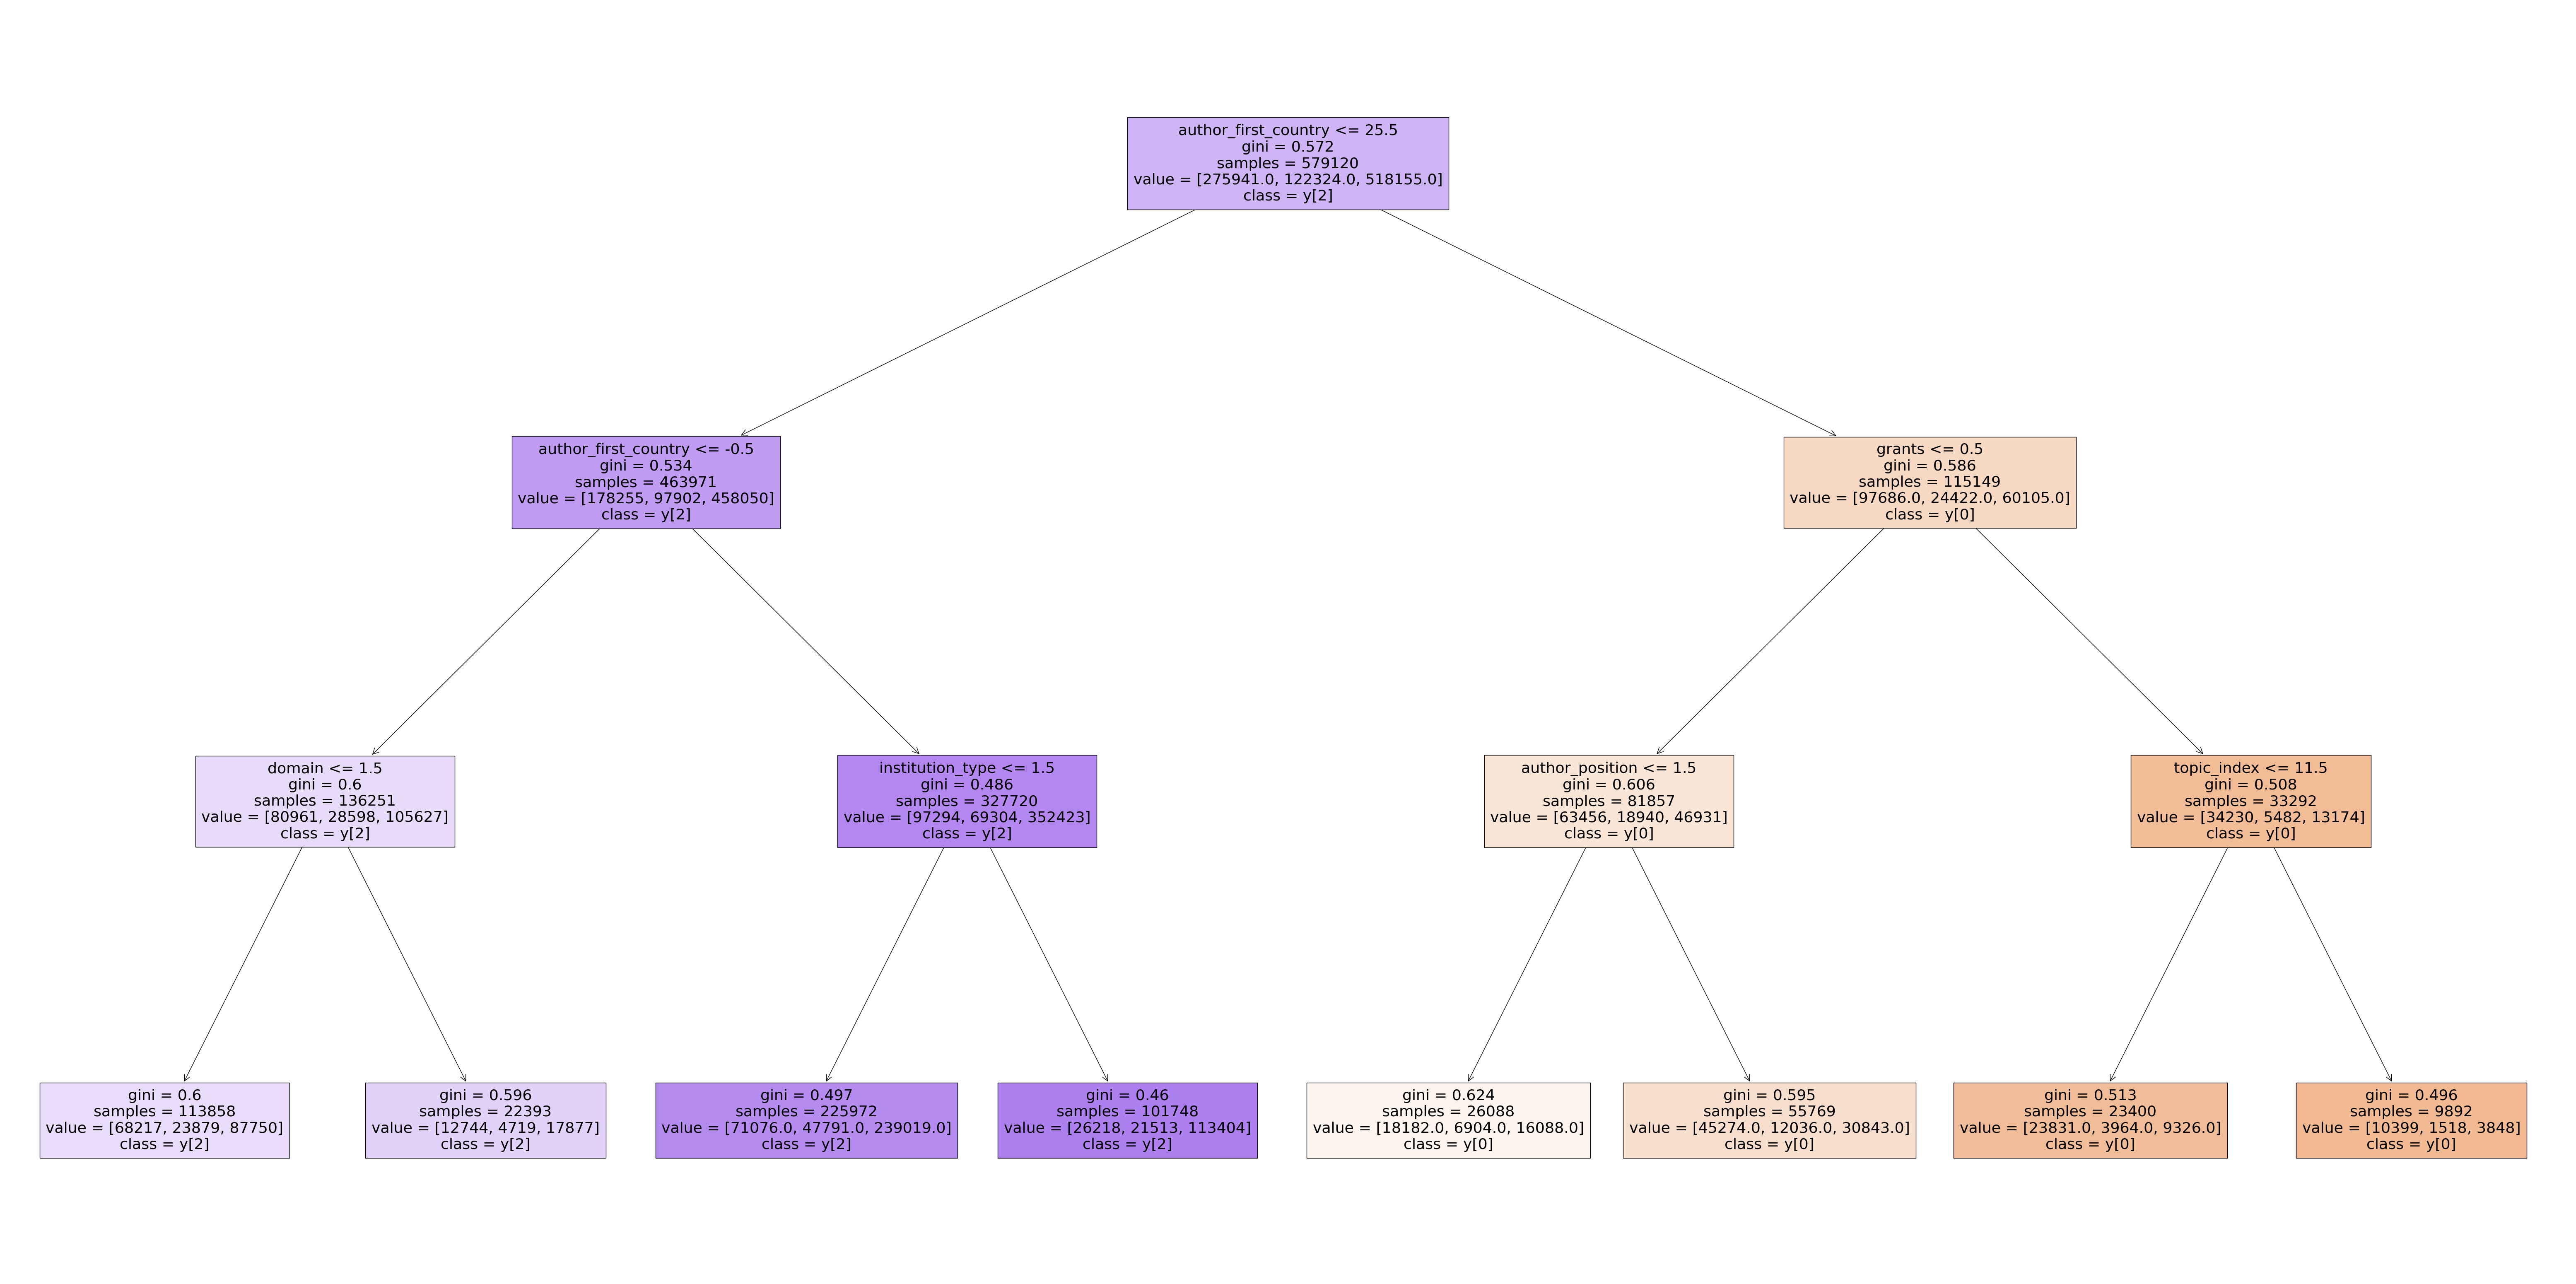

In [26]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns, class_names=True,filled=True);

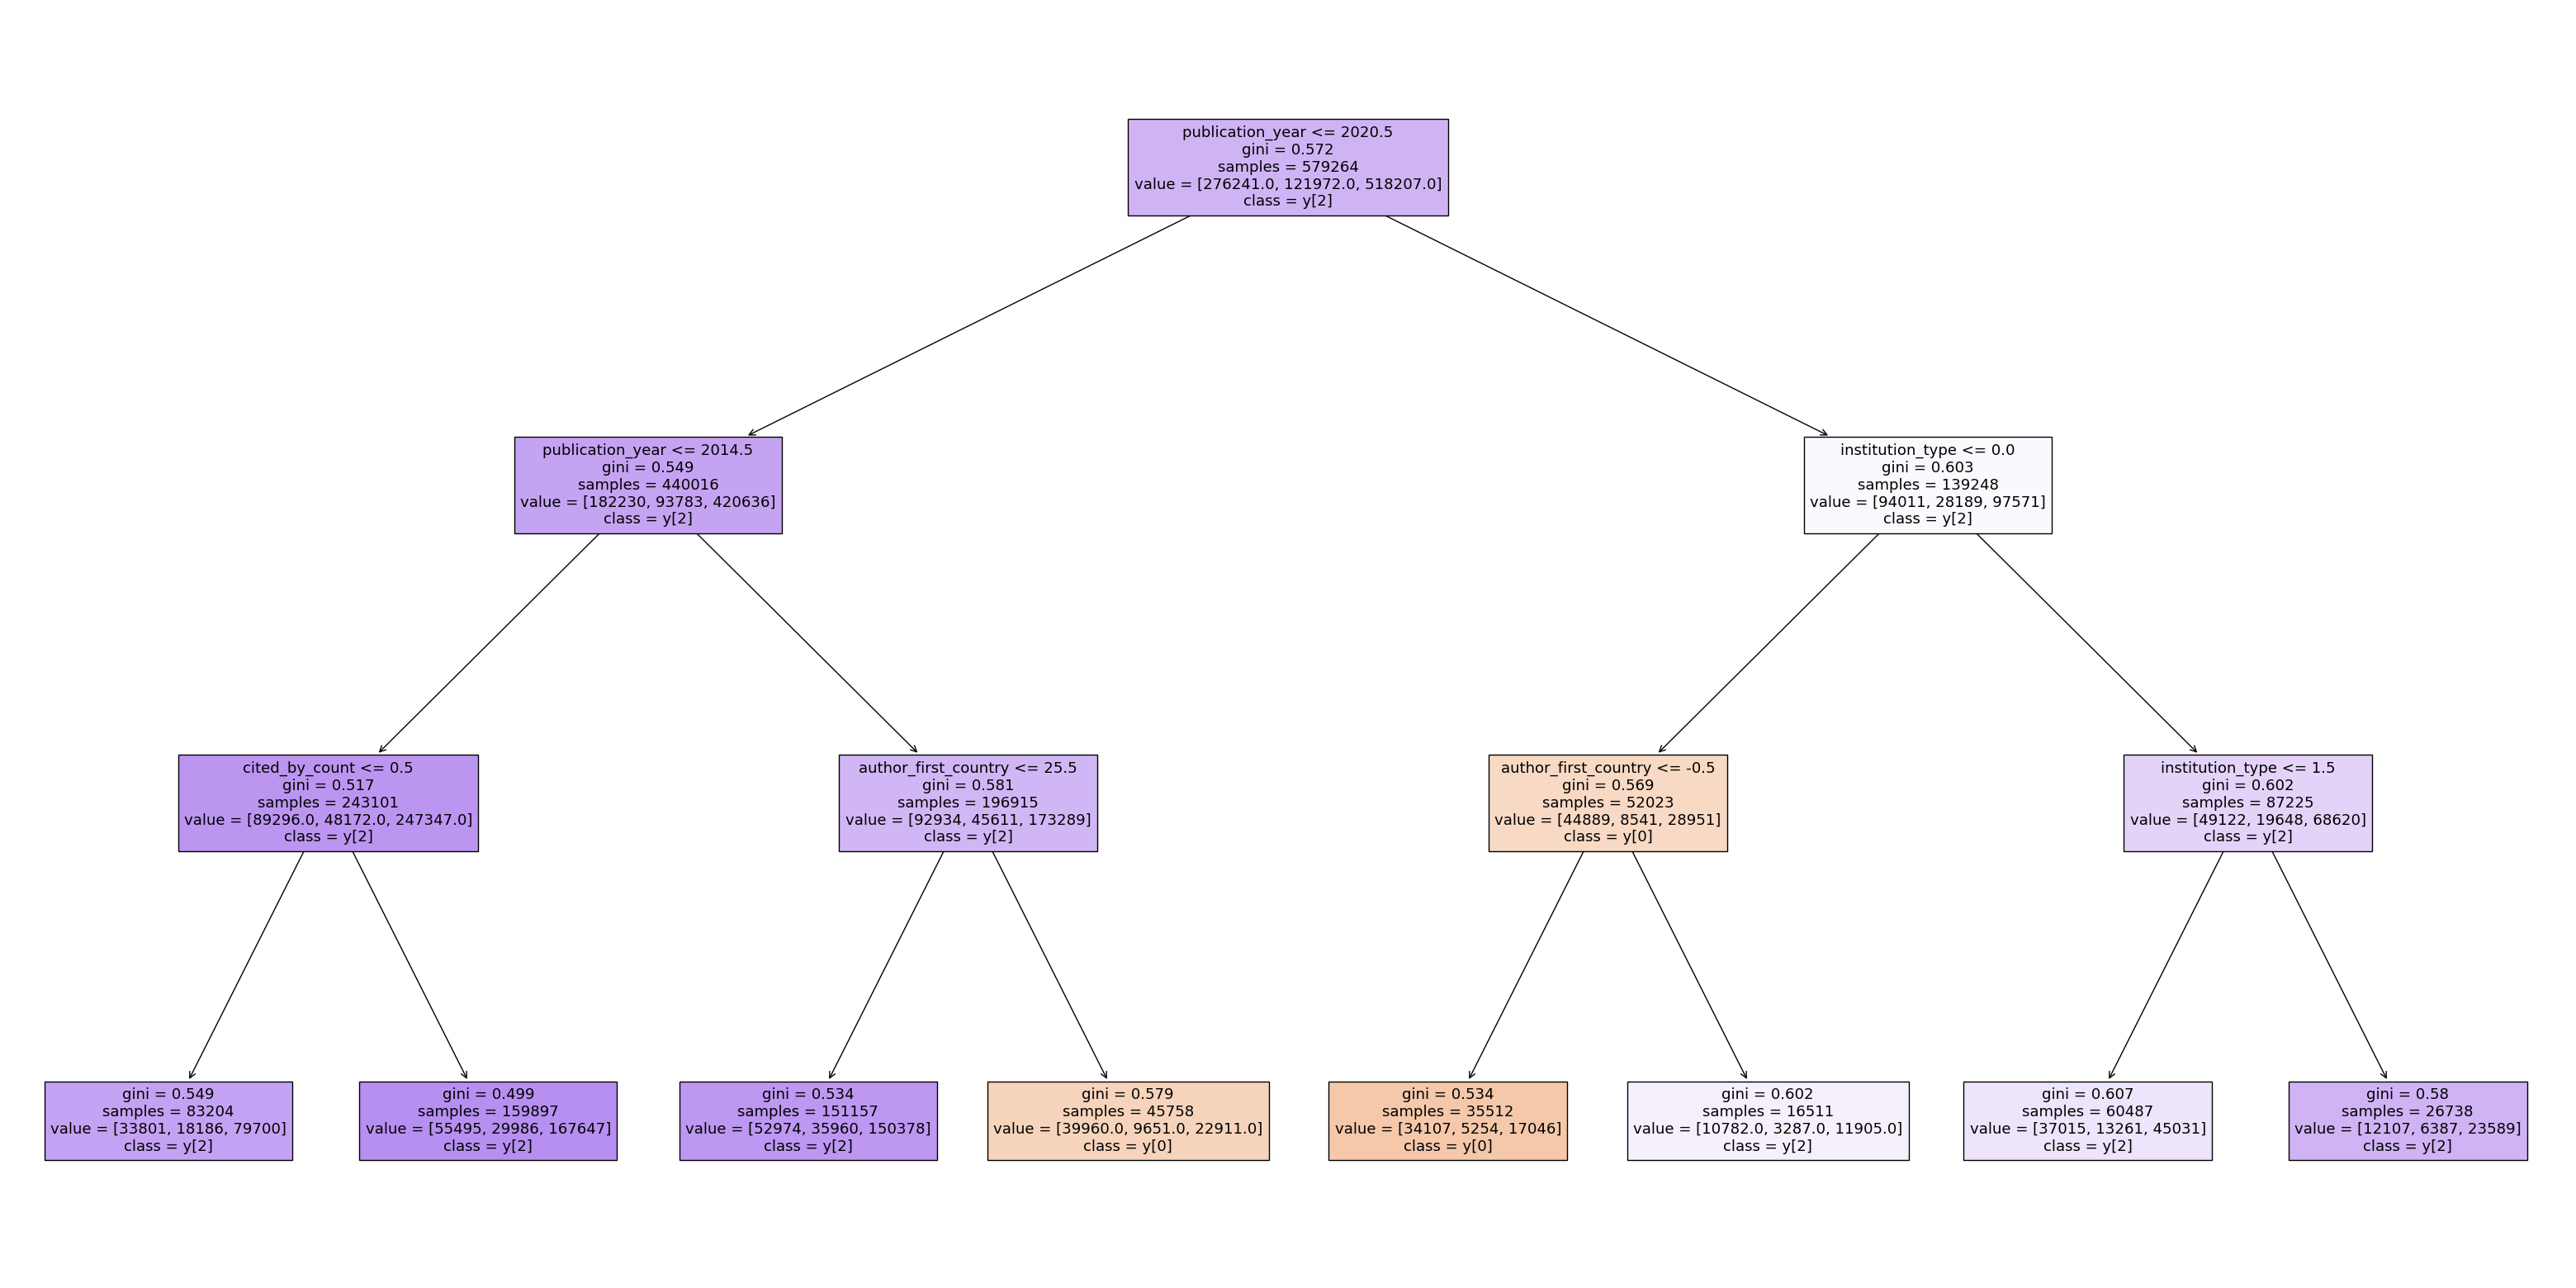

In [42]:
from sklearn.tree import plot_tree
plt.figure(figsize=(40,20))
plot_tree(rf_best.estimators_[7], feature_names = X.columns,class_names=True,filled=True);

### Feature importance 

In [27]:
rf_best.feature_importances_


array([1.02183698e-01, 2.63014896e-02, 2.05817616e-02, 0.00000000e+00,
       3.11068261e-02, 1.01877195e-03, 6.56034380e-02, 7.22549275e-02,
       6.80263226e-01, 6.33619458e-04, 5.22420760e-05])

In [28]:
imp_df = pd.DataFrame({
    "Variable": X_train.columns,
    "Impact": rf_best.feature_importances_
})

imp_df.sort_values(by="Impact", ascending=False) #let's maybe put it in a bar plot 

,Variable,Impact
8,author_first_country,0.680263
0,publication_year,0.102184
7,institution_type,0.072255
6,institution_id,0.065603
4,total_author_counts,0.031107
1,cited_by_count,0.026301
2,grants,0.020582
5,author_position,0.001019
9,topic_index,0.000634
10,domain,0.000052


### Plotting 

In [89]:
#actual vs predicted 

In [29]:
# Step 6: Model Evaluation
y_pred = rf_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6185480914164664
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.64      0.28      0.39    117882
         1.0       0.00      0.00      0.00     52438
         2.0       0.62      0.94      0.74    222432

    accuracy                           0.62    392752
   macro avg       0.42      0.41      0.38    392752
weighted avg       0.54      0.62      0.54    392752



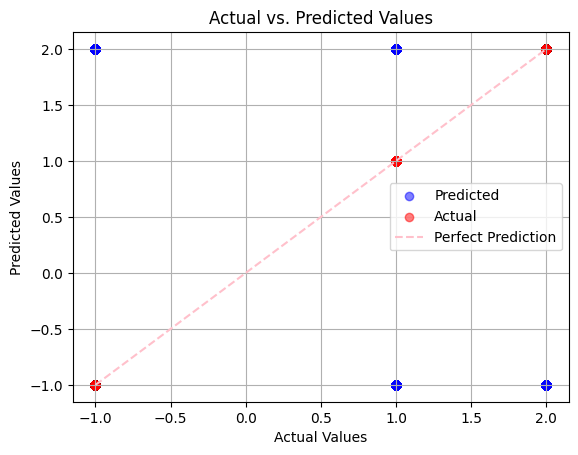

In [30]:

# Plot actual vs. predicted values, with different colors for y_test and y_pred
plt.scatter(y_test, y_pred, c='blue', label='Predicted', alpha=0.5)  # Plot predicted values with blue color
plt.scatter(y_test, y_test, c='red', label='Actual', alpha=0.5)  # Plot actual values with red color
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='pink', linestyle='--', label='Perfect Prediction')  # Plot perfect prediction line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()



(array([ 84769.,      0.,      0.,  46573.,      0., 242936.,      0.,
             0.,   5865.,  12609.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <BarContainer object of 10 artists>)

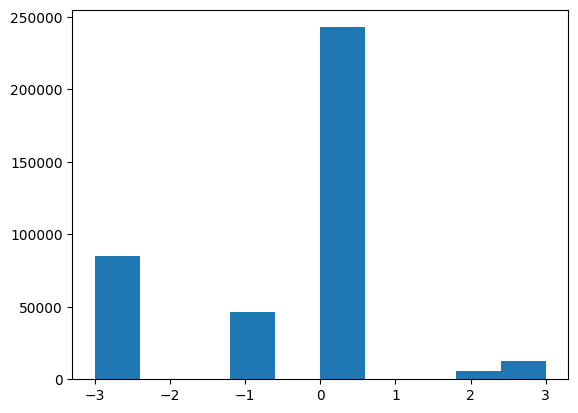

In [31]:
#residual plot 
y_residuals=y_test-y_pred

plt.hist(y_residuals) 

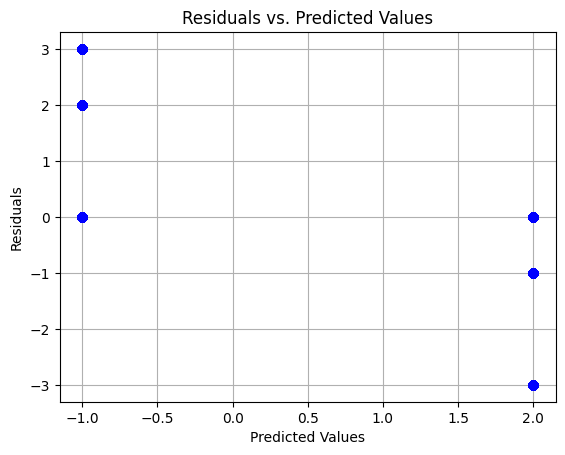

In [32]:


# Plot residuals against predicted values
plt.plot(y_pred, y_residuals, 'bo')  # Plot residuals against predicted values with blue circles
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.grid(True)
plt.show()



In [34]:
#feature versus target 
#Plotting individual features against the target variable can provide insights into their relationship. 
#You can use scatter plots with a regression line to visualize this relationship.

In [32]:
import matplotlib.pyplot as plt

def plot_feature_target_relation(X, y):
    num_features = X.shape[1]  # Number of features
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_features + 1) // num_cols  # Number of rows in the subplot grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    for i, feature in enumerate(X.columns):
        ax = axes[i]
        ax.scatter(X[feature], y, color='blue', label='Real Points')
        ax.set_title(f'Relationship between {feature} and Target')
        ax.set_xlabel(feature)
        ax.set_ylabel('Target')

    plt.tight_layout()
    plt.show()




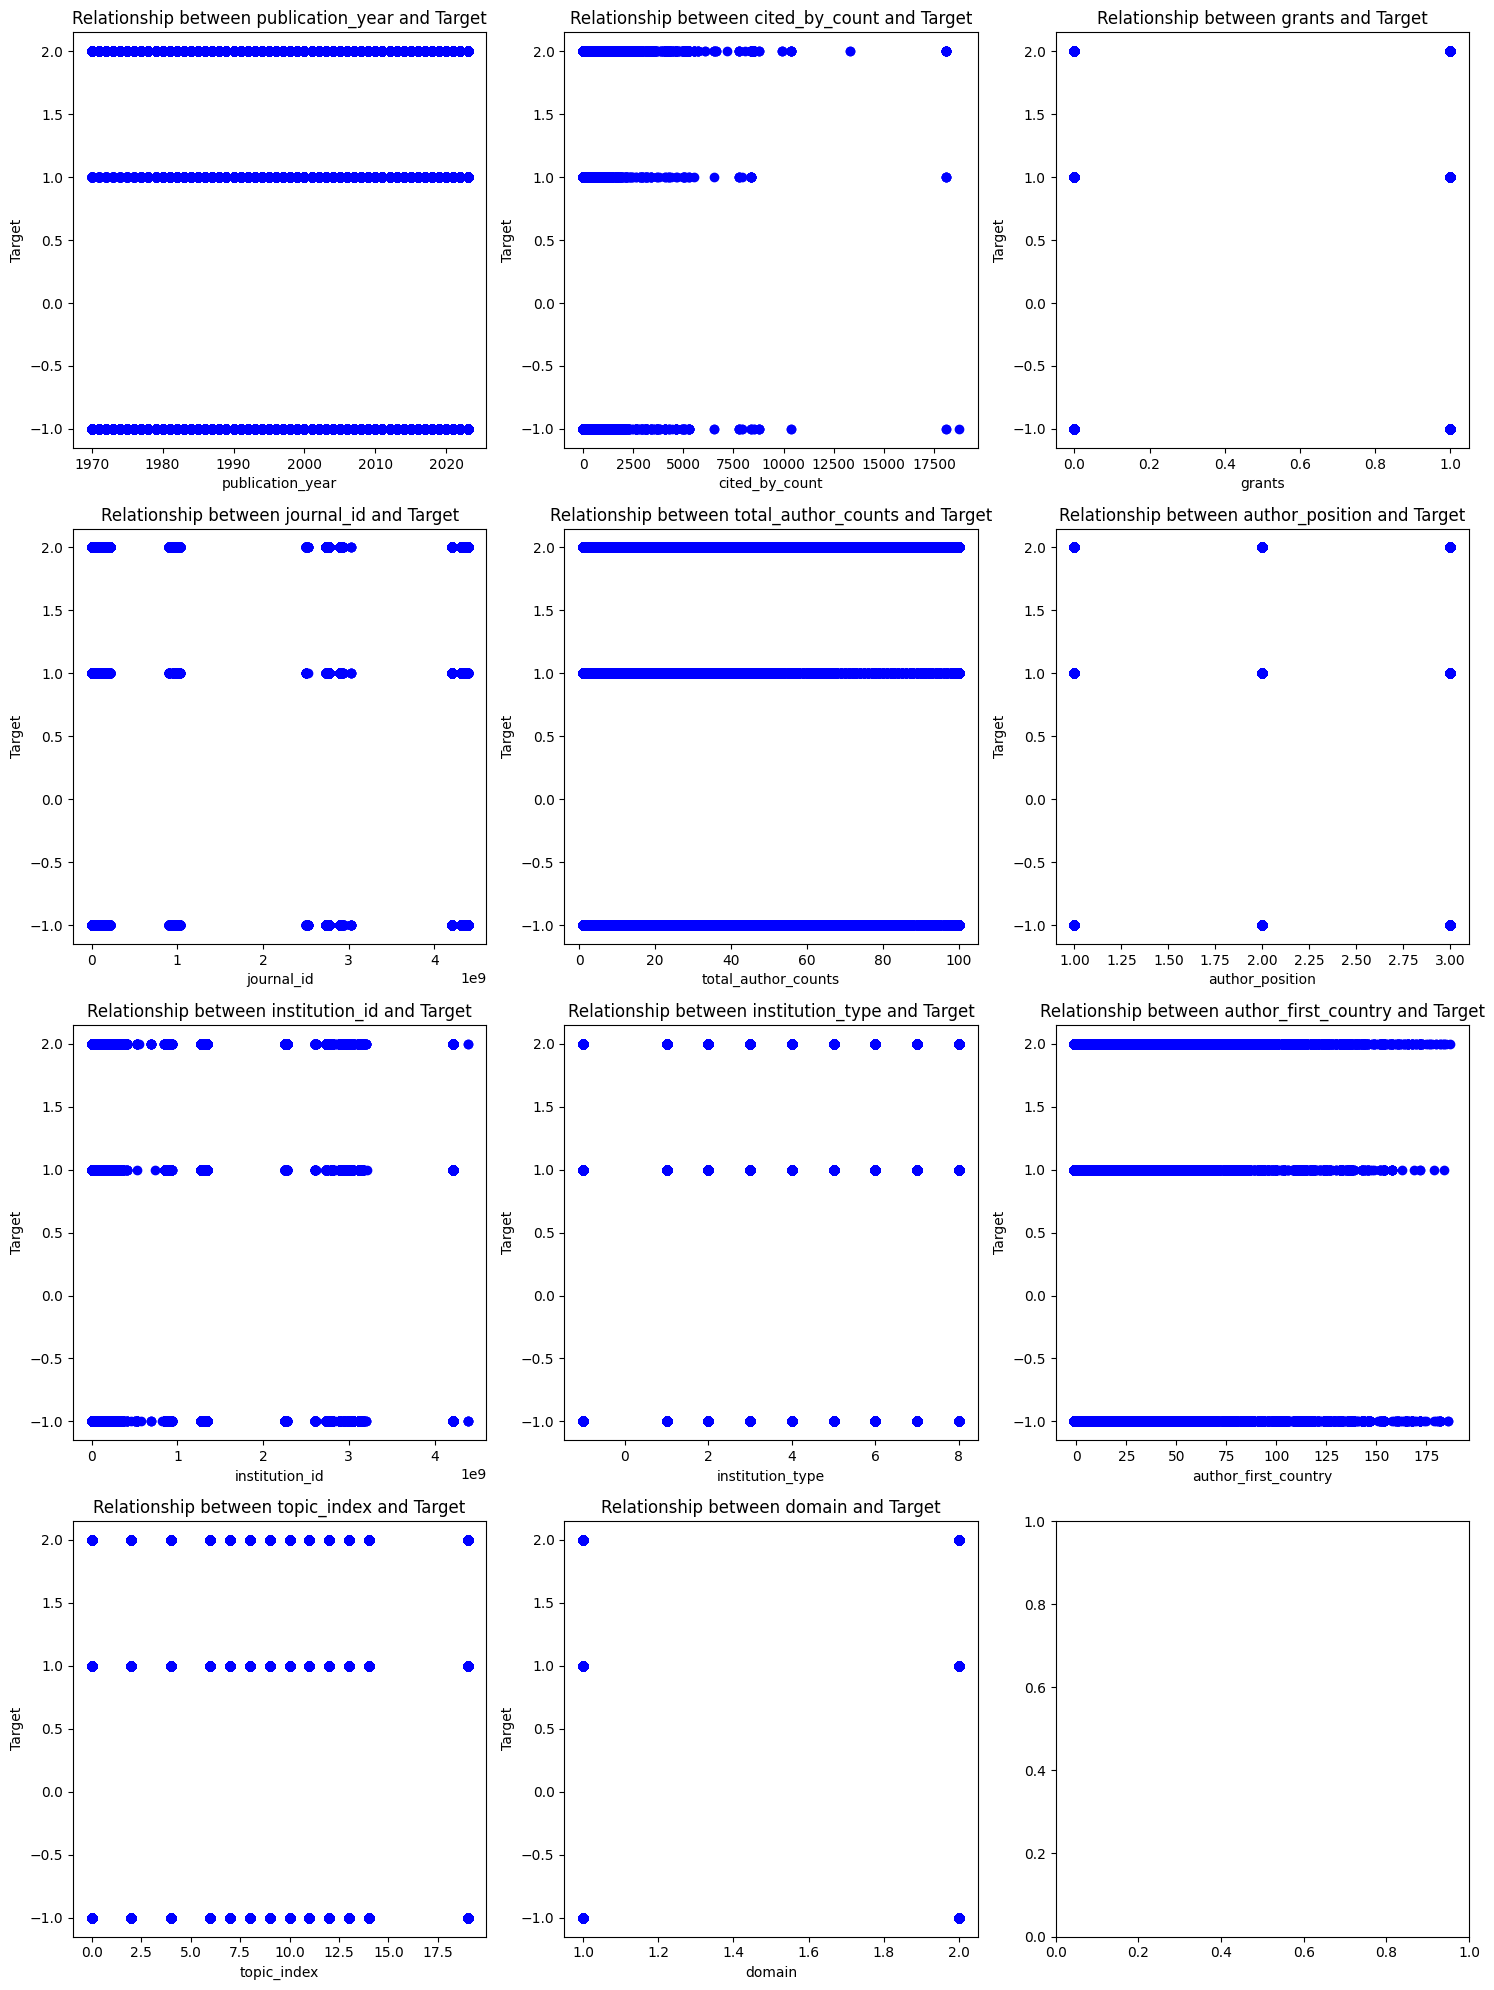

In [33]:
# Assuming X is your feature matrix and y is the target variable
plot_feature_target_relation(X, y)

In [45]:
# Concatenate X and y into a single DataFrame
data = pd.concat([X, y], axis=1)
sample_data=data.sample(100)

In [35]:
import seaborn as sns

# Concatenate X and y into a single DataFrame
data = pd.concat([X, y], axis=1)

# Create pair plot
sns.pairplot(data, hue='predicted_gender', diag_kind='hist')
plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x298df2700> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [37]:
print('test')

test


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assuming X and y are your features and target variable
# Fit RandomForestRegressor
regressor = RandomForestRegressor()

In [43]:
%%time
regressor.fit(X, y)

KeyboardInterrupt: 

In [ ]:
# Number of features
num_features = X.shape[1]

In [ ]:



# Set up subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, 6 * num_features))

# Generate X values for plotting the regression line
X_grid = np.linspace(min(X), max(X), 100)

# Loop through each feature and plot its relation to the target variable
for i in range(num_features):
    feature_values = X[:, i]
    ax = axes[i]
    
    # Plot data points
    ax.scatter(feature_values, y, color='blue', label='Data')
    
    # Predictions using the trained regressor
    y_pred = regressor.predict(X)
    
    # Plot the regression line
    ax.plot(X_grid, y_pred, color='green', label='Regression Line')
    
    # Set title and labels
    ax.set_title(f'Feature {i+1}')
    ax.set_xlabel(f'Feature {i+1}')
    ax.set_ylabel('Target')
    ax.legend()

plt.tight_layout()
plt.show()


# Jensen Shannon diff

In [24]:
import pandas as pd
from scipy.spatial.distance import jensenshannon

# Assuming df is your DataFrame with columns: gender, year, and 10 feature columns

# Group the DataFrame by gender and year
grouped = sample_data.groupby(['predicted_gender', 'publication_year'])

In [25]:


# Function to calculate probability distribution and Jensen-Shannon difference
def jensen_shannon_difference(group):
    # Calculate probability distribution for each feature
    probs = group.iloc[:, 2:].apply(lambda x: x / x.sum(), axis=1)
    
    # Compute Jensen-Shannon difference between the two distributions
    js_diff = jensenshannon(probs.iloc[0], probs.iloc[1])
    
    return js_diff




In [26]:
# Calculate Jensen-Shannon difference for each group
js_difference = grouped.apply(jensen_shannon_difference)


IndexError: single positional indexer is out-of-bounds

In [ ]:
js_difference

# LightGBM

https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python

In [27]:
# Troels foreslår LightGBM classification 

## install

In [4]:
!brew install libomp


==> Downloading https://formulae.brew.sh/api/formula.jws.json

==> Downloading https://formulae.brew.sh/api/cask.jws.json

To reinstall 18.1.2, run:
  brew reinstall libomp


In [5]:
pip install lightgbm


  Using cached lightgbm-4.3.0.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.3.0-py3-none-macosx_12_0_arm64.whl size=1390126 sha256=8485ee5999061f9704a2d5d8b6399b546228a7fd0cd7b9710a2518214af1d8ee
  Stored in directory: /Users/signebendsen/Library/Caches/pip/wheels/f4/d1/f4/3cd66516e5a05b0879846879dfb06e5a087f453adb405a5999
Successfully built lightgbm
Note: you may need to restart the kernel to use updated packages.


In [273]:
pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## model

In [365]:
import lightgbm as lgb


In [366]:
test_data=pd.concat([X, y], axis=1)

In [292]:
df=test_data.sample(10000)

In [293]:
#check how model deals with NaN 
#df.replace(-1, np.nan, inplace=True) 
#df.dropna(inplace=True)

In [294]:
# check the distribution of the target variable
df['predicted_gender'].value_counts()

predicted_gender
 2.0    5666
-1.0    2996
 1.0    1338
Name: count, dtype: int64

In [295]:
X = df.drop(columns={'predicted_gender'})
y = df['predicted_gender'] # target

# First example Build model 

In [ ]:
# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [84]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2435, number of negative: 513
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 854
[LightGBM] [Info] Number of data points in the train set: 2948, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.825984 -> initscore=1.557426
[LightGBM] [Info] Start training from score 1.557426


LGBMClassifier()

## Model prediction

In [85]:
# predict the results
y_pred=clf.predict(X_test)

## View Accuracy

In [86]:
# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.7769


## Compare train and test set accuracy

In [87]:
y_pred_train = clf.predict(X_train)


In [88]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.9213


## Check for overfitting 

In [89]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9213
Test set score: 0.7769


## Confusion-matrix

In [90]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

#hvorfor giver den 3x3 matrix? 

Confusion matrix

 [[ 10 249]
 [ 33 972]]

True Positives(TP) =  10

True Negatives(TN) =  972

False Positives(FP) =  249

False Negatives(FN) =  33


<Axes: >

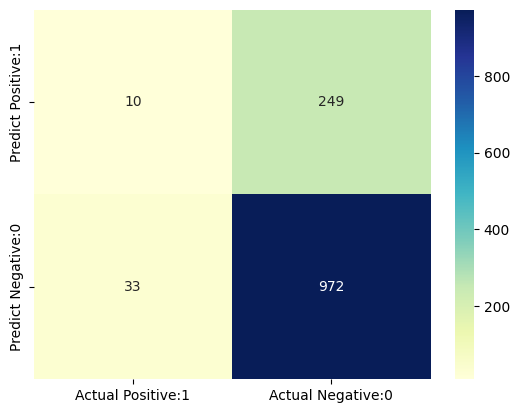

In [91]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## Classification metrices 

In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.23      0.04      0.07       259
         2.0       0.80      0.97      0.87      1005

    accuracy                           0.78      1264
   macro avg       0.51      0.50      0.47      1264
weighted avg       0.68      0.78      0.71      1264



# Second example 

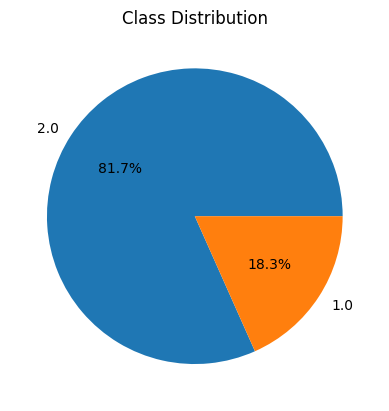

In [95]:
# Count the frequency of each class in the 'Outcome' column 
temp = df['predicted_gender'].value_counts() 
  
# Create a pie chart to represent class distribution 
plt.pie(temp.values, labels=temp.index.values, autopct='%1.1f%%') 
  
# Set the title of the chart 
plt.title("Class Distribution") 
  
# Display the pie chart 
plt.show()

#not equally distributed - should we use data balancing techniques ??

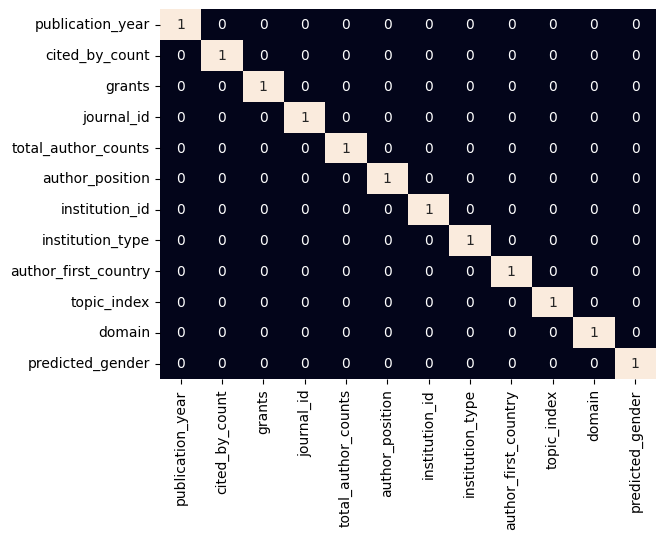

In [106]:
import seaborn as sb 

# Compute the correlation matrix and create a heatmap with correlations above 0.7 
sb.heatmap(df.corr() > 0.7
           , cbar=False, annot=True) 
  
# Display the heatmap 
plt.show() 

#plot shows that there are no highly correlated features to be removed (considered best practice) 

In [109]:
# Extracting features and target variable 
features = df.drop('predicted_gender', axis=1) 
target = df['predicted_gender'] 
  
# Splitting the data into training and validation sets with an 80-20 ratio 
X_train, X_val, Y_train, Y_val = train_test_split( 
    features, target, random_state=2023, test_size=0.20) 
  
# Displaying the shapes of the training and validation sets 
X_train.shape, X_val.shape 

((3369, 11), (843, 11))

In [110]:

# Initialize a StandardScaler 
scaler = StandardScaler() 
  
# Fit the scaler to the training data and transform both training and validation sets 
scaler.fit(X_train) 
X_train = scaler.transform(X_train) 
X_val = scaler.transform(X_val) 

In [116]:
# Training a LightGBM Classifier 
from lightgbm import LGBMClassifier 

# Initialize a LightGBM Classifier with 'auc' as the evaluation metric 
clf = LGBMClassifier(metric='auc') 

# Fit the model on the training data 
clf.fit(X_train, Y_train) 

# Make predictions on the training and validation sets 
y_train = model.predict(X_train) 
y_val = model.predict(X_val) 


[LightGBM] [Info] Number of positive: 2748, number of negative: 621
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 3369, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.815672 -> initscore=1.487298
[LightGBM] [Info] Start training from score 1.487298


In [112]:
# Creating LightGBM Dataset and Setting Parameters 
import lightgbm as lgb 

# Create LightGBM Datasets for training and validation 
train_data = lgb.Dataset(X_train, label=Y_train) 
test_data = lgb.Dataset(X_val, label=Y_val, reference=train_data) 

# Define hyperparameters and objective for LightGBM 
params = { 
	'objective': 'binary', 
	'metric': 'auc', 
	'boosting_type': 'gbdt', 
	'num_leaves': 31, 
	'learning_rate': 0.05, 
	'feature_fraction': 0.9, 
} 


In [113]:
# Training a LightGBM Model 
num_round = 100

# Train a LightGBM model using defined parameters, training data, and specified number of rounds 
model = lgb.train(params, train_data, 
				num_round, valid_sets=[test_data]) 


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 3369, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 3369, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there 

In [114]:
# Calculating and Printing ROC-AUC Scores 
from sklearn.metrics import roc_auc_score as ras 
  
# Calculate and print the ROC-AUC score for the training and validation sets 
print("Training ROC-AUC: ", ras(Y_train, y_train)) 
print("Validation ROC-AUC: ", ras(Y_val, y_val)) 

Training ROC-AUC:  0.7347407688683556
Validation ROC-AUC:  0.5201068024346361


In [122]:
clf.feature_importances_


array([354, 467,  24, 566, 309,  77, 580,  63, 317, 225,  18], dtype=int32)

In [120]:
X.columns

Index(['publication_year', 'cited_by_count', 'grants', 'journal_id',
       'total_author_counts', 'author_position', 'institution_id',
       'institution_type', 'author_first_country', 'topic_index', 'domain'],
      dtype='object')

In [121]:
imp_df = pd.DataFrame({
    "Variable": X.columns,
    "Impact": clf.feature_importances_
})

imp_df.sort_values(by="Impact", ascending=False) #let's maybe put it in a bar plot 

,Variable,Impact
6,institution_id,580
3,journal_id,566
1,cited_by_count,467
0,publication_year,354
8,author_first_country,317
4,total_author_counts,309
9,topic_index,225
5,author_position,77
7,institution_type,63
2,grants,24


# Third example 

https://www.kaggle.com/code/mrtgocer/from-zero-to-hero-lightgbm-classifier and 
https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

In [296]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [297]:
# These parameters will be used in gridsearch and will be found optimum parameters
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': [0.01,0.1,0.5],
    'subsample_for_bin': [20000,50000,100000,120000,150000],
    'min_child_samples': [20,50,100,200,500],
    'colsample_bytree': [0.6,0.8,1],
    "max_depth": [5,10,50,100]
}

In [298]:
lgbm = LGBMClassifier() # Shortname the LGBMClassifier()

lgbm.fit(X_train, y_train) # Train the lgbm on train sets

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 11
[LightGBM] [Info] Start training from score -1.195674
[LightGBM] [Info] Start training from score -1.991431
[LightGBM] [Info] Start training from score -0.578034


LGBMClassifier()

In [299]:
#%%time #run this on our actual data - skip for now as it is time consuming 
#lgbm_cv = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1, verbose=2) #5 fold cross validation
#lgbm_cv.fit(X_train, y_train) #try all parameters
#lgbm_cv.best_params_ #print optimum parameters

In [300]:
#use the best_params to run the tuned model below

In [537]:
lgbm_tuned = LGBMClassifier(boosting_type = 'gbdt',
                            class_weight = None,
                            min_child_samples = 20,
                            num_leaves = 30,
                            subsample_for_bin = 20000,
                            learning_rate=0.01, 
                            max_depth=10, 
                            n_estimators=40, 
                            colsample_bytree=0.6) # LightGBM Classifier with optimum paramteres

lgbm_tuned.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)], callbacks=[lgb.record_evaluation(eval_result)],
          eval_metric='logloss') #Fit the model with the optimum parameters

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 11
[LightGBM] [Info] Start training from score -1.195674
[LightGBM] [Info] Start training from score -1.991431
[LightGBM] [Info] Start training from score -0.578034


LGBMClassifier(colsample_bytree=0.6, learning_rate=0.01, max_depth=10,
               n_estimators=40, num_leaves=30, subsample_for_bin=20000)

In [538]:
y_test_pred = lgbm_tuned.predict(X_test) #Predicting X_test to find the solutiın

score = round(accuracy_score(y_test, y_test_pred), 3) # Find the accuracy of y_test and predicitons, and round the result
print(score)

0.59


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

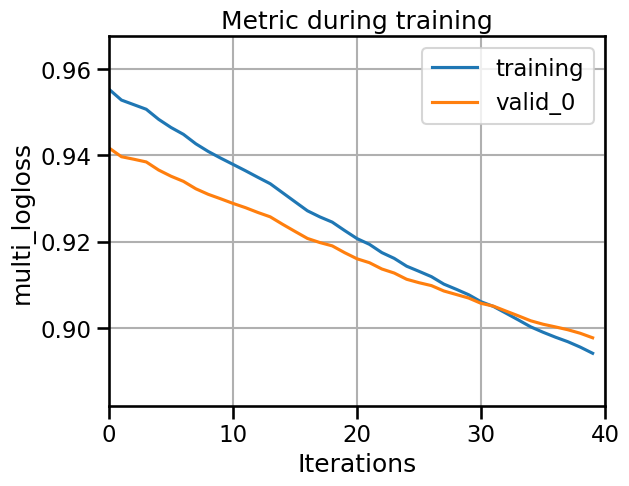

In [539]:
lgb.plot_metric(lgbm_tuned)

ImportError: You must install graphviz and restart your session to plot tree.

<Figure size 8000x4000 with 0 Axes>

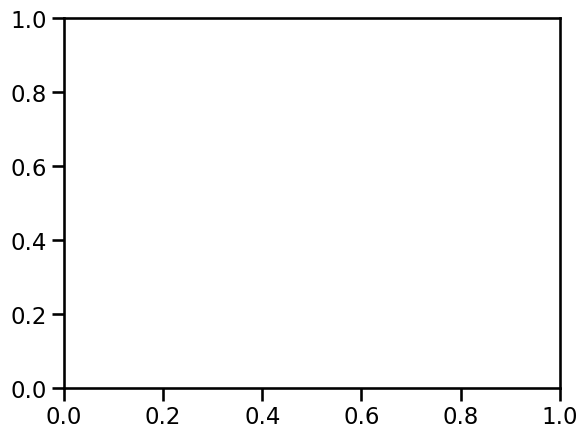

In [545]:
#this should I work I just think it doesn't due to our data right now 

lgb.plot_tree(lgbm_tuned,figsize=(30,40))



<Axes: xlabel='importance', ylabel='features'>

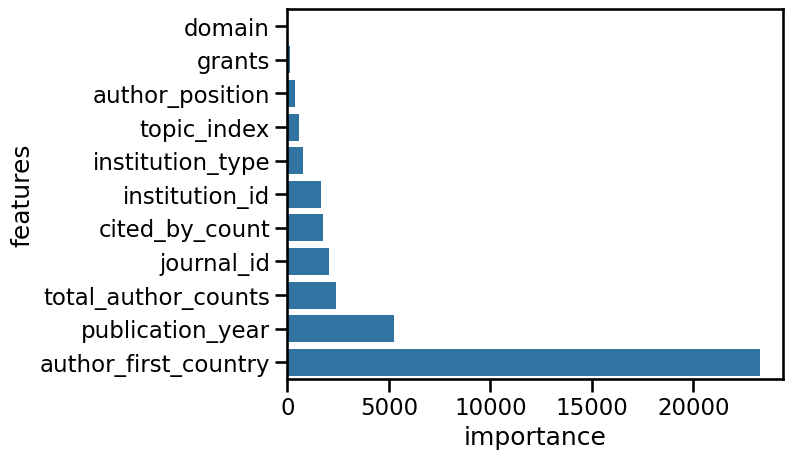

In [305]:
sns.set_context("talk")
#style.use('fivethirtyeight')

fi = pd.DataFrame()
fi['features'] = X.columns.values.tolist()
fi['importance'] = lgbm_tuned.booster_.feature_importance(importance_type='gain')

sns.barplot(x='importance', y='features', data=fi.sort_values(by='importance', ascending=True))

In [549]:
from sklearn.metrics import confusion_matrix

metrics.plot_confusion_matrix(lgbm_tuned,X_test,y_test,cmap='Blues_r')


NameError: name 'metrics' is not defined

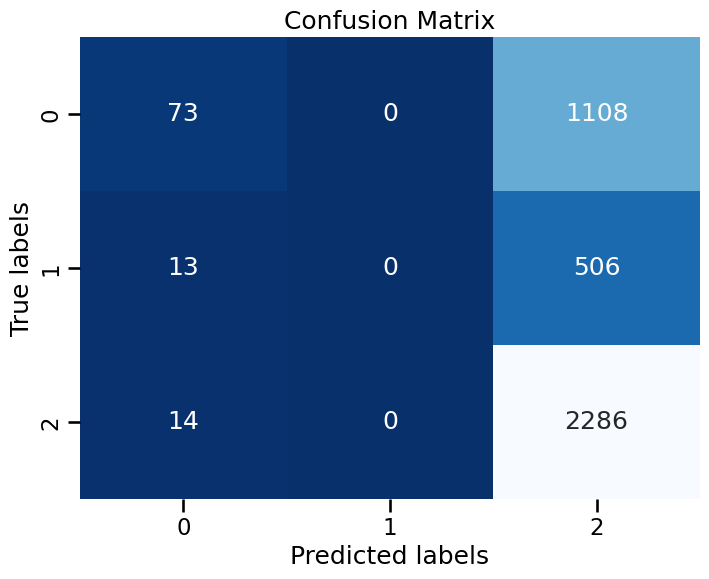

In [312]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming lgbm_tuned is your trained LightGBM model and x_test, y_test are your test data
y_pred = lgbm_tuned.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [316]:
from sklearn.metrics import classification_report

# Assuming 'model' is your trained classifier and X_test, y_test are your test data
print(classification_report(y_test, lgbm_tuned.predict(X_test)))


              precision    recall  f1-score   support

        -1.0       0.73      0.06      0.11      1181
         1.0       0.00      0.00      0.00       519
         2.0       0.59      0.99      0.74      2300

    accuracy                           0.59      4000
   macro avg       0.44      0.35      0.28      4000
weighted avg       0.55      0.59      0.46      4000



# UMAP

In [ ]:
# PCA 

In [28]:
# Troels foreslår UMAP clustering 

In [336]:
pip install umap

Note: you may need to restart the kernel to use updated packages.


In [320]:
pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 36.6 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
Using cached Cython-0.29.37-py2.py3-none-any.whl (989 kB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp311-cp311-macosx_12_0_arm64.whl size=732548 sha256=b5d969dc7db1b4b18a5be63b49b12896d500c55a21367c4bb38d48c4ff0b4363
  Stored in directory: /Users/signebendsen/Library/Caches/pip/wheels/4e/8c/6f/d0495e4e40cbd27a8c7330d4e963837e099d6e16014dbdcdb5
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8
Note: you may need to restart the kernel to use updated packages.


In [326]:
pip install umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 11.8 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=791ee6f630cc8100caf49359a9d3b9779dcef73055107e95392493326fd988fa
  Stored in directory: /Users/signebendsen/Library/Caches/pip/wheels/de/07/2e/814a6ee82e37528f2044a609a431028375b149bc31f03c0e27
Successfully built umap-learn
Note: you may need to restart the kernel to use updated packages.


In [327]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

## New example 

https://www.reneshbedre.com/blog/umap-in-python.html

In [350]:
import pandas as pd

df = pd.read_csv("https://reneshbedre.github.io/assets/posts/gexp/ath_sc_expression.csv")
df.head(2)

# set first column as index
df = df.set_index('cells')

# check the dimension (rows, columns)
df.shape


(4406, 2000)

In [352]:
import umap

embedding = UMAP(random_state=42).fit_transform(df.values)

embedding.shape


(4406, 2)

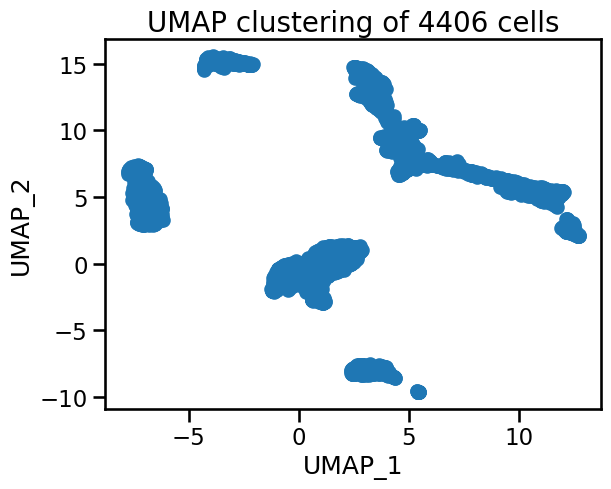

In [353]:
import matplotlib.pyplot as plt

plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title('UMAP clustering of 4406 cells', fontsize=20)
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.show()

In [356]:
from sklearn.cluster import DBSCAN
from collections import Counter

# here eps parameter is very important and optimizing eps is essential
# for well defined clusters. I have run DBSCAN with several eps values
# and got good clusters with eps=3
get_clusters = DBSCAN(eps = 3, min_samples = 4).fit_predict(embedding)

# check unique clusters
set(get_clusters)


# get count of samples in each cluster
Counter(get_clusters)


Counter({1: 1940, 0: 1175, 2: 774, 4: 288, 3: 229})

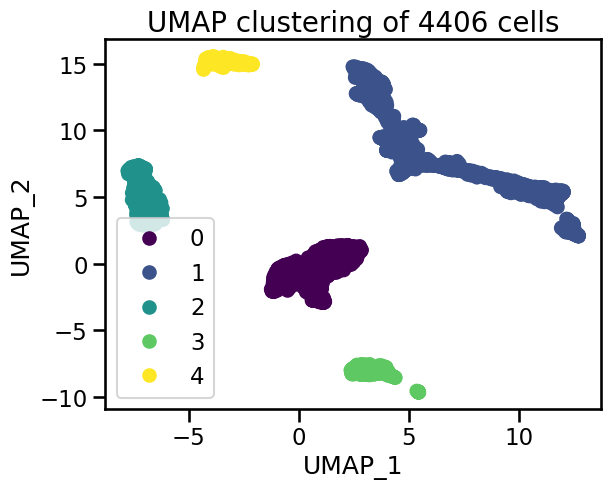

In [357]:
s = plt.scatter(embedding[:, 0], embedding[:, 1], c = get_clusters, cmap = 'viridis')
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.legend(s.legend_elements()[0], list(set(get_clusters)))
plt.title('UMAP clustering of 4406 cells', fontsize=20)
plt.show()

In [358]:
# on my data 

In [475]:
df=test_data[0:10000]

In [476]:
df.shape


(10000, 12)

In [491]:
import umap

embedding = UMAP(random_state=42).fit_transform(df.values)

embedding.shape


(10000, 2)

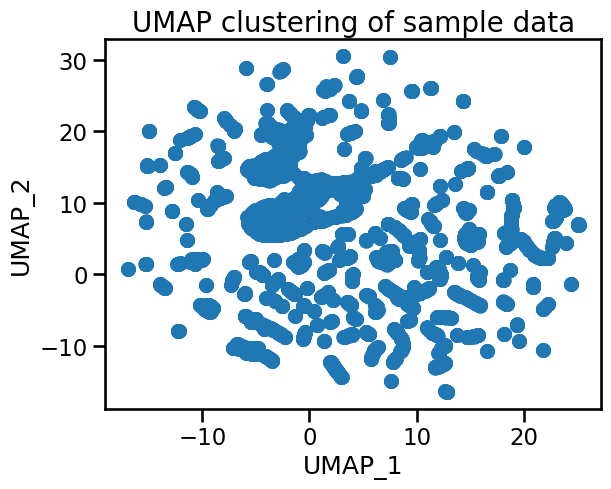

In [492]:
import matplotlib.pyplot as plt

plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title('UMAP clustering of sample data', fontsize=20)
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.show()

In [520]:
from sklearn.neighbors import NearestNeighbors


#estimate opmtial hyperparameters 

def get_kdist_plot(X=None, k=None, radius_nbrs=10):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


In [521]:
X = df.drop(columns={'predicted_gender'})
y = df['predicted_gender'] # target

21


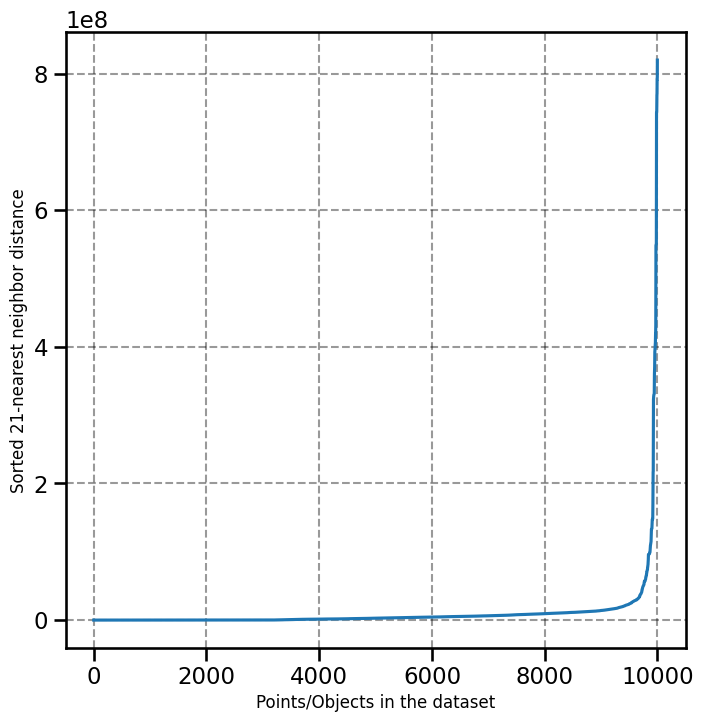

In [522]:
k = 2 * X.shape[-1] - 1 # k=2*{dim(dataset)} - 1
print(k)
get_kdist_plot(X=X, k=k)

In [525]:
from sklearn.cluster import DBSCAN
from collections import Counter

# here eps parameter is very important and optimizing eps is essential
# for well defined clusters. I have run DBSCAN with several eps values
# and got good clusters with eps=3
get_clusters = DBSCAN(eps = 1, min_samples = 4).fit_predict(embedding)

# check unique clusters
set(get_clusters)

# get count of samples in each cluster
Counter(get_clusters)

print('N clusters:', len(set(get_clusters)))

N clusters: 149


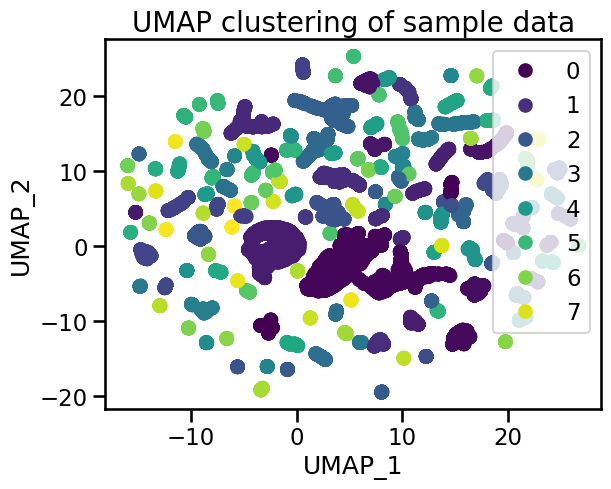

In [533]:
s = plt.scatter(embedding[:, 0], embedding[:, 1], c = get_clusters, cmap = 'viridis')
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.legend(s.legend_elements()[0], list(set(get_clusters)))
plt.title('UMAP clustering of sample data', fontsize=20)
plt.show()